# Basic Definitions تعاریف پایه

In [3]:
;; -----------------------------------------------
;;               Imports
;; -----------------------------------------------

(require '[clojupyter.misc.helper :as helper])
(require '[clojupyter.misc.display :as display])

(helper/add-dependencies '[org.clojure/clojure "1.9.0"])
(helper/add-dependencies '[http-kit "2.2.0"])
(helper/add-dependencies '[org.clojure/data.json "0.2.6"])
(helper/add-dependencies '[clj-time "0.14.2"])
(helper/add-dependencies '[incanter "1.9.2"])
(helper/add-dependencies '[gorillalabs/neo4j-clj "0.5.0"])


(require '[org.httpkit.client :as http])
(require '[clojure.data.json :as json])

(require '[clj-time.core :as timecore])
(require '[clj-time.format :as timefmt])
(require '[clj-time.coerce :as timecoerce])

(require '[neo4j-clj.core :as db])


;; -----------------------------------------------
;;               Definitions
;; -----------------------------------------------
(def Genesis  "000000000019d6689c085ae165831e934ff763ae46a2a6c172b3f1b60a8ce26f") ; 2009
(def Blk200K  "000000000000034a7dedef4a161fa058a2d67a173a90155f3a2fe6fc132e0ebf") ; 2013
(def Blk350K  "0000000000000000053cf64f0400bb38e0c4b3872c38795ddde27acb40a112bb") ; 2015-03
(def Blk400K  "000000000000000004ec466ce4732fe6f1ed1cddc2ed4b328fff5224276e3f6f") ; 2016
(def Blk450K  "0000000000000000014083723ed311a461c648068af8cef8a19dcd620c07a20b") ; 2017-01
(def Recent   "00000000000000000029a7d26968251b90d7fdf8c741154deefdaca446c90c84") ; 2018-04
(def Empty    "00000000000000000023fe60cae1a9a54a6db0ae906e5fe78652ca3f35f2b5ac")

(def Miner    "1Hz96kJKF2HLPGY15JWLB5m9qGNxvt8tHJ")

(def BaseUrl      "http://127.0.0.1:8332/rest/")
(def BlockUrl     "http://127.0.0.1:8332/rest/block/")
(def FastBlockUrl "http://127.0.0.1:8332/rest/block/notxdetails/")
(def TxUrl        "http://127.0.0.1:8332/rest/tx/")
 
;; -----------------------------------------------
;;               Functions
;; -----------------------------------------------

(defn get-info [] 
    (let [response @(http/get (str BaseUrl "chaininfo.json"))]
        (json/read-json (response :body))))

(defn get-tx [txhash] 
    (let [response @(http/get (str TxUrl txhash ".json"))]
        (json/read-json (response :body))))

(defn get-block [blockhash] 
    (let [response @(http/get (str BlockUrl blockhash ".json"))]
        (json/read-json (response :body))))

(defn get-fastblock [blockhash] 
    (let [response @(http/get (str FastBlockUrl blockhash ".json"))]
        (json/read-json (response :body))))

(defn next-blockhash [block]
    (block :nextblockhash))

(defn prev-blockhash [block]
    (block :previousblockhash))

(defn last-blockhash [] ((get-info) :bestblockhash))

(defn nth-blockhash [n & [base-blockhash]]
    (loop [i n current-hash (or base-blockhash Genesis)]
        (if (zero? i) 
            current-hash
            (recur (dec i) (next-blockhash (get-fastblock current-hash))))))

(defn nth-block 
    ([n]                (get-block (nth-blockhash n)))
    ([n base-blockhash] (get-block (nth-blockhash n base-blockhash))))

;; height 
(defn get-ordinal [blockhash] 
    (loop [n 0 currenthash blockhash]
        (if (= currenthash Genesis) 
            n 
            (recur (inc n) (prev-blockhash (get-fastblock currenthash))))))

(defn unix2date [unixint] 
    (timefmt/unparse (timefmt/formatters :mysql) (timecoerce/from-long unixint)))

(defn get-time [block] (-> block :time (* 1000) unix2date))

(defn tx-count [block] (count (block :tx)))

(defn get-vout [block tx-num]
    (-> block :tx (nth tx-num) :vout))
    
(defn get-vin [block tx-num]
    (-> block :tx (nth tx-num) :vin))

(println "Done!")

Done!


# Finding Empty Blocks یافتن بلوک های خالی => ذخیره ی عمق، تاریخ و تولید کننده آنها

In [2]:
(defn block-empty? [block] 
    (if (and (= 1 (tx-count block)) 
             (some (partial = :coinbase) (-> block (get-vin 0) first keys)))
        true false)) 
;این تابع تمامی بلوک های بین دو بلوک داده شده را جستجو می کند
(defn empty-blocks [start-hash stop-hash N]
    (loop [current-hash start-hash n 0 result {}]
        (if (or (= current-hash stop-hash) (= n N)) result
            (let [block (get-block current-hash)] 
                (recur (next-blockhash block) (inc n) (if (block-empty? block) 
                                                                 (update result (-> block :tx first :vout first :scriptPubKey :addresses first) conj [(block :height) (block :time)]) 
                                                                 result))))))

;انجام محاسبه روی بلاکچین
(println (time (def EB (empty-blocks Blk200K Blk350K 10000))))

; یافتن آدرس های با بیش از یک بار واریز توسط بلاک های خالی
(println (filter #(> (count (EB %)) 1) (keys EB))) 
;(1NEU779yvLaFk39k4Q3QdLjwpWTdWCbzqL 19PkHafEN18mquJ9ChwZt5YEFoCdPP5vYB 14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer)

"Elapsed time: 880976.717731 msecs"
#'user/EB
(1NEU779yvLaFk39k4Q3QdLjwpWTdWCbzqL 19PkHafEN18mquJ9ChwZt5YEFoCdPP5vYB 14cZMQk89mRYQkDEj8Rn25AnGoBi5H6uer)


In [ ]:
;(helper/add-javascript "https://code.highcharts.com/highcharts.js")

In [60]:
;(def raw-data (map #(+ (* 22 (+ % (Math/random)) 78)) (range)))
;(def data-1 (take 500 raw-data))
(def data (sort-by first (map first (vals EB))))
;(def Block-Number (map first data))
;(def Block-Time (map second data))


(defn plot-highchart [highchart-json]
  (let [id (str (java.util.UUID/randomUUID))
        code (format "Highcharts.chart('%s', %s );" id, (json/write-str highchart-json))]
      (display/hiccup-html 
        [:div [:div {:id id :style {:background-color "red"}}]
                   [:script code]])))



(plot-highchart {:chart {:type "bar"}
                 :xAxis {:categories (map #(unix2date (* 1000 %)) Block-Time)}
                 :yAxis {:title {:text "Empty Blocks"}}
                 :title {:text "بلوک های خالی"}
                 :series [{ :data Block-Number
                            ;:xAxis 1
                            ;|:yAxis 1
                            :zIndex 1
                            :marker {:fillColor "white"
                                    :lineWidth 2}}]})



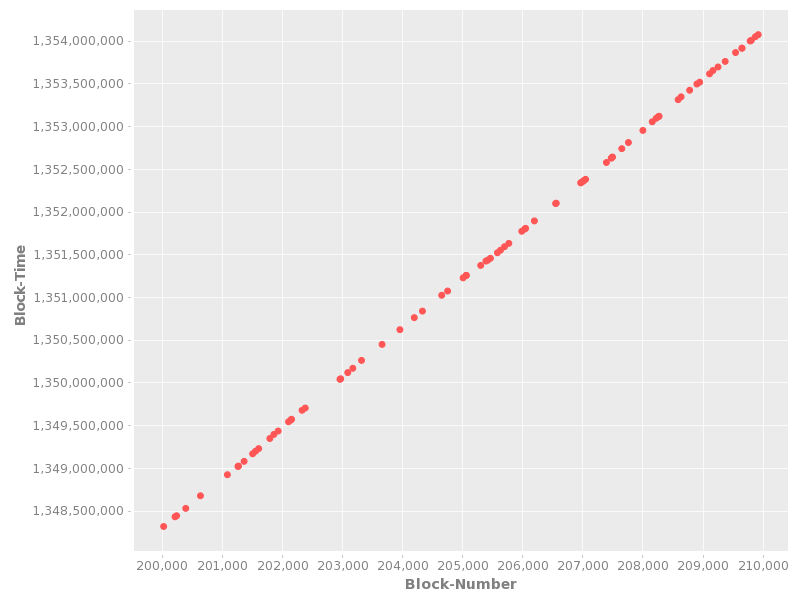

In [27]:
; JVM
(-> (scatter-plot Block-Number Block-Time)
    (.createBufferedImage 800 600))

In [11]:
; HTML
(display/hiccup-html 
    [:ul 
     [:li "a " [:i "emphatic"] " idea"]
     [:li "a " [:b "bold"] " idea"]
     [:li "an " [:span {:style "text-decoration: underline;"} "important"] " idea"]])



a emphatic idea a bold idea an important idea

In [46]:
; HTML
(display/hiccup-html
    [:svg {:height 100 :width 100 }
            [:circle {:cx 50 :cy 40 :r 40 :fill "red"}]])

# Wallet Analysis  اتصال به پایگاه داده کمکی برای تحلیل کیف های پول

In [6]:

(def local-db
  (db/connect "bolt://localhost:7687" "neo4j" "Zblock.IR"))

#'user/local-db

##  Neo4j Query on Blocks

In [7]:
(json/pprint-json (db/execute (db/get-session local-db) 
                              "MATCH (start :block {height:100})-[chain :chain*0..1]->(block :block)-[:coinbase]->(cb :output)-[:in]->(coinbasetx :tx)
                              RETURN block, cb"))

[{"block":
  {"prevblock":
   "00000000cd9b12643e6854cb25939b39cd7a1ad0af31a9bd8b2efe67854b1995",
   "hash":
   "000000007bc154e0fa7ea32218a72fe2c1bb9f86cf8c9ebf9a715ed27fdb229a",
   "time":1231660825,
   "merkleroot":
   "2d05f0c9c3e1c226e63b5fac240137687544cf631cd616fd34fd188fc9020866",
   "bits":"1d00ffff",
   "size":215,
   "txcount":1,
   "version":1,
   "nonce":1573057331,
   "height":100},
  "cb":{"value":5000000000}},
 {"block":
  {"prevblock":
   "00000000a8ed5e960dccdf309f2ee2132badcc9247755c32a4b7081422d51899",
   "hash":
   "00000000cd9b12643e6854cb25939b39cd7a1ad0af31a9bd8b2efe67854b1995",
   "time":1231660146,
   "merkleroot":
   "33a4592d4d8dc04304361ad7bcd96fe23fa801db6d7d917074f75c732079a569",
   "bits":"1d00ffff",
   "size":215,
   "txcount":1,
   "version":1,
   "nonce":2500462385,
   "height":99},
  "cb":{"value":5000000000}}]


In [9]:
;;This returns a block with all the transactions that are included in it
(json/pprint-json (db/execute (db/get-session local-db)  
                              "MATCH (block :block)<-[:inc]-(tx :tx) 
                              WHERE block.height=42500
                              RETURN block, tx"))


[{"block":
  {"prevblock":
   "000000001b500cca7a499c34bbdb1eb9a02ae0789e351739fd479bcd54a73d48",
   "hash":
   "000000004368763ffb8e808e605c05d8feb7f0eeae425ba38fb54dce833fe4dd",
   "time":1267091908,
   "merkleroot":
   "7fa93fd3ac5501ce24a1866d2180f9f2b1d4608a425655c5fbf49a93fc218f3e",
   "bits":"1c43b3e5",
   "size":215,
   "txcount":1,
   "version":1,
   "nonce":97337286,
   "height":42500},
  "tx":
  {"txid":
   "7fa93fd3ac5501ce24a1866d2180f9f2b1d4608a425655c5fbf49a93fc218f3e",
   "locktime":0,
   "size":134,
   "version":1,
   "fee":0}}]


## Neo4j Query on Transactions

In [10]:
;; This will give you a transaction node with all of its inputs and all of its outputs, 
;; and any addresses those outputs are locked to. 
;; It will also return the block(s) the transaction is included in.
(json/pprint-json (db/execute (db/get-session local-db)  
                              "MATCH (inputs)-[:in]->(tx:tx)-[:out]->(outputs)
                              WHERE tx.txid='a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d'
                              OPTIONAL MATCH (inputs)-[:locked]->(inputsaddresses)
                              OPTIONAL MATCH (outputs)-[:locked]->(outputsaddresses)
                              OPTIONAL MATCH (tx)-[:inc]->(block)
                              RETURN inputs, tx, outputs, block, inputsaddresses, outputsaddresses"))

[{"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "1f54bafc70859e908d3bcad89f1071d180a9773d2a3548b547926ebc8d7486bb:0",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8

  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "073636d643eca967219c9243795b78e2b55ac28311611b7344962b4a85e276b5:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075

   "index":
   "6f4a63e1645dffc3366a3d2e0b34c4348e5fe74f3998c91a1176f117c7f2c6b8:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQK

   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "096f85124d670e3da13cb55880ec272e486fb423b034797b0c48c0a5825046b3:0",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":100000000000

   "749e6d90ff5215373ac1b70a114d48f18ea3bd09aca50a9bdc5fb0c4cd87717e:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}}

   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "58a71de0624df8d191a3168f091f07e9892b08517b12d9c1976bb042cb26477c:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "bloc

  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":


   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "9d62e6dadaafde34c0eff8f9f85829f2451dd8379e0ccdd364114f8722100090:0",
   "value":8000000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",

   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "c9f48d7

   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "7bfea77535fbbc3baa1de262d42b629a3bbbc7578c3fe603dfa42eb9779493f6:0",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "0000

   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "5960b4f4bb0e5482091a6e09297e9009c633ee5aad3e5699dec25115bbab6bdb:0",
   "value":1000000},
  "tx

   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "07c8b28197c8c84bcb77104e299ee7ae75f3543f74d8d37217de54b6da85c72c:0",
   "value":90000000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd64

  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "0c55a81ef1961d91f0240b37344633a3cf6beb45463b7199df2fd91e673347db:0",
   "value":20000000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e21

   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "396475d4c3011ea97c31aa1132e63c335cea9b3b1b573ca93ef135dbee0a66cc:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d

  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "82e2ca47f77910707b7f92d901e5f6c46bf9d051ff78feaf390cbdc943ba94c6:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302

  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "21959ee208412d667658dc422190c61532351a53849a63ec5cb004cc421b6dd6:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"

   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "height":57043},
  "inputsaddresses":{"address":"1XPTgDRhN8RFnzniWCddobD9iKZatrvH4"},
  "outputsaddresses":
  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "8dbc8f799a740116fdfe9ea0f07ad0b782337f96b708c1476a6c06aea567a1d0:1",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee

  {"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"}},
 {"inputs":
  {"scriptPubKey":
   "76a91405bf3a3aea6335a3949c0a351ff3afcba884e12588ac",
   "index":
   "97a45b12de40e0a491065ada61f5a99fa60fe2e7d455652ea009716b649662e3:0",
   "value":1000000},
  "tx":
  {"txid":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d",
   "locktime":0,
   "size":23620,
   "version":1,
   "fee":99000000},
  "outputs":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000},
  "block":
  {"prevblock":
   "0000000013e7e85518dac94d012d73253d3fdac5c30c4143b177f3086f129580",
   "hash":
   "00000000152340ca42227603908689183edc47355204e7aca59383b0aaac1fd8",
   "time":1274552191,
   "merkleroot":
   "5c1d2211f598cd6498f42b269fe3ce4a6fdb40eaa638f86a0579c4e63a721b5a",
   "bits":"1c159c24",
   "size":23835,
   "txcount":2,
   "version":1,
   "nonce":188133155,
   "heigh

## Neo4j Query on Address

In [11]:
;; Show all of the outputs that have been locked to an address
(json/pprint-json (db/execute (db/get-session local-db)  
                              "MATCH (address :address)<-[:locked]-(output :output)
                              WHERE address.address='17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ'
                              RETURN address, output"))


[{"address":{"address":"17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ"},
  "output":
  {"scriptPubKey":
   "76a91446af3fb481837fadbb421727f9959c2d32a3682988ac",
   "index":
   "a1075db55d416d3ca199f55b6084e2115b9345e16c5cf302fc80e9d5fbf5d48d:0",
   "value":1000000000000}}]


In [12]:
;; Address Balance
;; You can calculate the balance of an address by summing the values of the unspent outputs that are locked to an address.
(json/pprint-json (db/execute (db/get-session local-db) 
                              "MATCH (address :address)<-[:locked]-(output :output) 
                              WHERE address.address='1XPTgDRhN8RFnzniWCddobD9iKZatrvH4' 
                              AND NOT (output)-[:in]->(:tx) 
                              RETURN sum(output.value) as balance"))


[{"balance":821155000000}]


In [14]:
;; This query allows you to see if two address are connected by a series of transactions. It also returns a path if there are common intermediary addresses.
(print (db/execute (db/get-session local-db) 
                              "MATCH (start :address {address:'17SkEw2md5avVNyYgj6RiXuQKNwkXaxFyQ'}), (end :address {address:'1XPTgDRhN8RFnzniWCddobD9iKZatrvH4'})
                              MATCH path=shortestPath( (start)-[:in|:out|:locked*]-(end) )
                              RETURN path"))

({:path #object[org.neo4j.driver.internal.value.PathValue 0x6651c6d5 path[(372597)<-[455885:locked]-(372596), (372596)<-[455884:out]-(372595), (372595)<-[455874:in]-(361637), (361637)-[440804:locked]->(302680)]]})

## Neo4j Historical Analysis

In [15]:
;;finds all non-coinbase transactions in the first 1000 blocks
(json/pprint-json (db/execute (db/get-session local-db) 
                              "MATCH (block:block)-[:inc]-(tx:tx)
                              WHERE block.height < 1000
                                  AND not exists((tx)<-[:in]-(:coinbase))
                              RETURN
                                  block.height AS block,
                                  tx.txid AS transaction,
                                  size((tx)<-[:in]-()) AS inputs,
                                  size((tx)-[:out]->()) AS outputs,
                                  tx.fee / tx.size AS fee_satoshis_per_byte
                              ORDER BY block"))

[{"block":170,
  "transaction":
  "f4184fc596403b9d638783cf57adfe4c75c605f6356fbc91338530e9831e9e16",
  "inputs":1,
  "outputs":2,
  "fee_satoshis_per_byte":0},
 {"block":181,
  "transaction":
  "a16f3ce4dd5deb92d98ef5cf8afeaf0775ebca408f708b2146c4fb42b41e14be",
  "inputs":1,
  "outputs":2,
  "fee_satoshis_per_byte":0},
 {"block":182,
  "transaction":
  "591e91f809d716912ca1d4a9295e70c3e78bab077683f79350f101da64588073",
  "inputs":1,
  "outputs":2,
  "fee_satoshis_per_byte":0},
 {"block":183,
  "transaction":
  "12b5633bad1f9c167d523ad1aa1947b2732a865bf5414eab2f9e5ae5d5c191ba",
  "inputs":1,
  "outputs":2,
  "fee_satoshis_per_byte":0},
 {"block":187,
  "transaction":
  "4385fcf8b14497d0659adccfe06ae7e38e0b5dc95ff8a13d7c62035994a0cd79",
  "inputs":1,
  "outputs":1,
  "fee_satoshis_per_byte":0},
 {"block":221,
  "transaction":
  "298ca2045d174f8a158961806ffc4ef96fad02d71a6b84d9fa0491813a776160",
  "inputs":1,
  "outputs":1,
  "fee_satoshis_per_byte":0},
 {"block":248,
  "transaction":
  